In [49]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [50]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [51]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [52]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [53]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [54]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [55]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [56]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


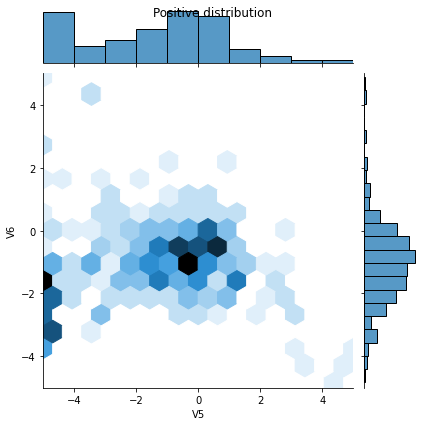

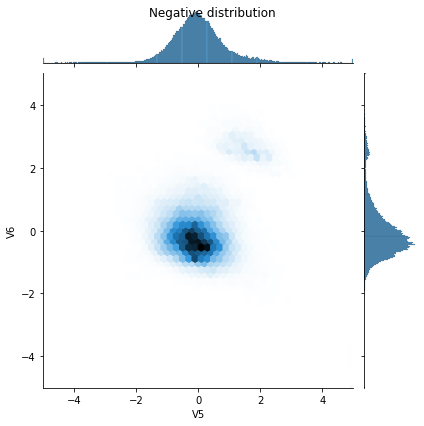

In [57]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [58]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [59]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [60]:
model = make_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                480       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.predict(train_features[:10])

array([[0.12402797],
       [0.1478357 ],
       [0.17400666],
       [0.26595095],
       [0.13739039],
       [0.06583188],
       [0.2683696 ],
       [0.22032437],
       [0.08920533],
       [0.14259504]], dtype=float32)

In [62]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2429


In [63]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [64]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00058159],
       [0.00136049],
       [0.00420598],
       [0.00092503],
       [0.00224187],
       [0.00738157],
       [0.00239584],
       [0.00330745],
       [0.00187664],
       [0.00168282]], dtype=float32)

In [65]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0115


In [76]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [77]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00139538],
       [0.00122616],
       [0.00029684],
       [0.0001619 ],
       [0.00183362],
       [0.00071109],
       [0.00027442],
       [0.00016926],
       [0.0012586 ],
       [0.00373949]], dtype=float32)

In [78]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0199


In [79]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [80]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [81]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

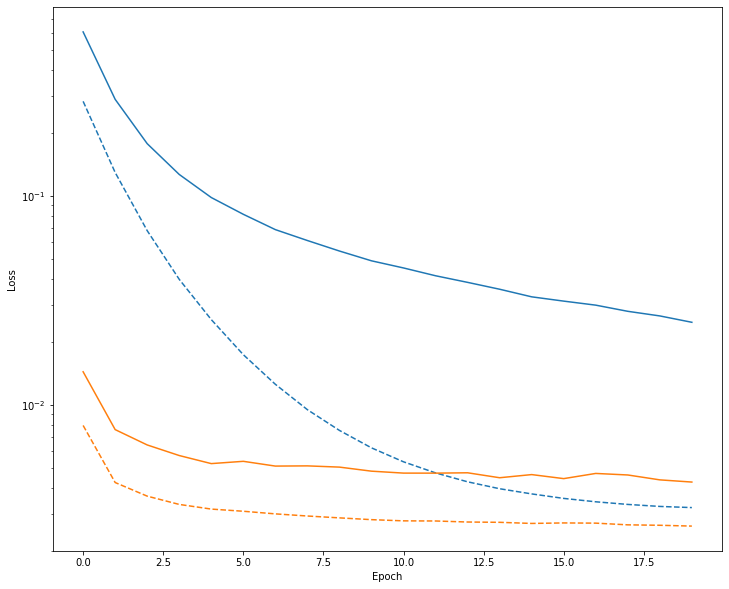

In [82]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [83]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 3s 16ms/step - loss: 0.0144 - tp: 71.0000 - fp: 13.0000 - tn: 227433.0000 - fn: 328.0000 - accuracy: 0.9985 - precision: 0.8452 - recall: 0.1779 - auc: 0.6784 - prc: 0.2157 - val_loss: 0.0079 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 45490.0000 - val_fn: 78.0000 - val_accuracy: 0.9983 - val_precision: 1.0000 - val_recall: 0.0127 - val_auc: 0.8969 - val_prc: 0.5931
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0077 - tp: 80.0000 - fp: 26.0000 - tn: 181930.0000 - fn: 240.0000 - accuracy: 0.9985 - precision: 0.7547 - recall: 0.2500 - auc: 0.8558 - prc: 0.4184 - val_loss: 0.0041 - val_tp: 46.0000 - val_fp: 4.0000 - val_tn: 45486.0000 - val_fn: 33.0000 - val_accuracy: 0.9992 - val_precision: 0.9200 - val_recall: 0.5823 - val_auc: 0.9362 - val_prc: 0.7898
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0062 - tp: 154.0000 - fp: 30.0000 - tn: 181926.0000 - fn: 166.0000 - accuracy

In [84]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

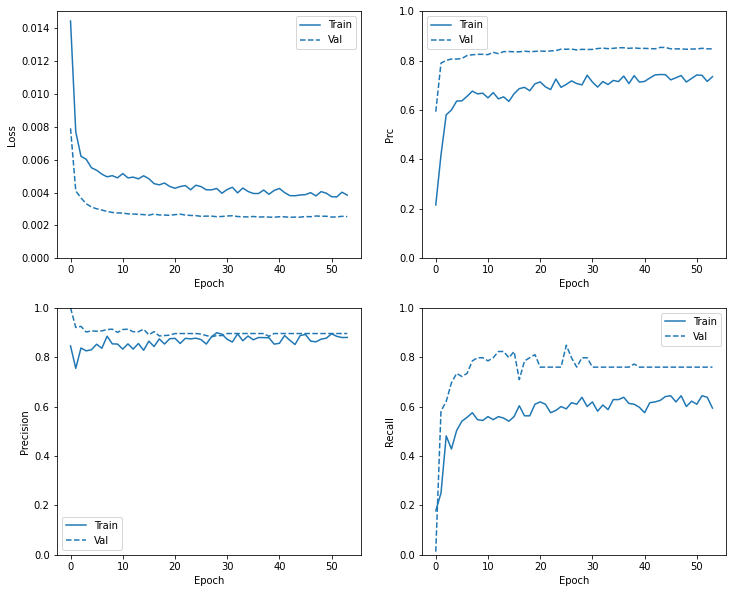

In [85]:
plot_metrics(baseline_history)

In [86]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [87]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0022884581703692675
tp :  71.0
fp :  8.0
tn :  56861.0
fn :  22.0
accuracy :  0.9994733333587646
precision :  0.8987341523170471
recall :  0.7634408473968506
auc :  0.9674634337425232
prc :  0.8645837306976318

Legitimate Transactions Detected (True Negatives):  56861
Legitimate Transactions Incorrectly Detected (False Positives):  8
Fraudulent Transactions Missed (False Negatives):  22
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  93


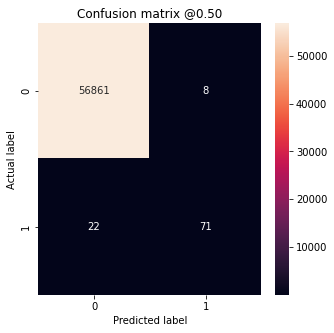

In [88]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [89]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

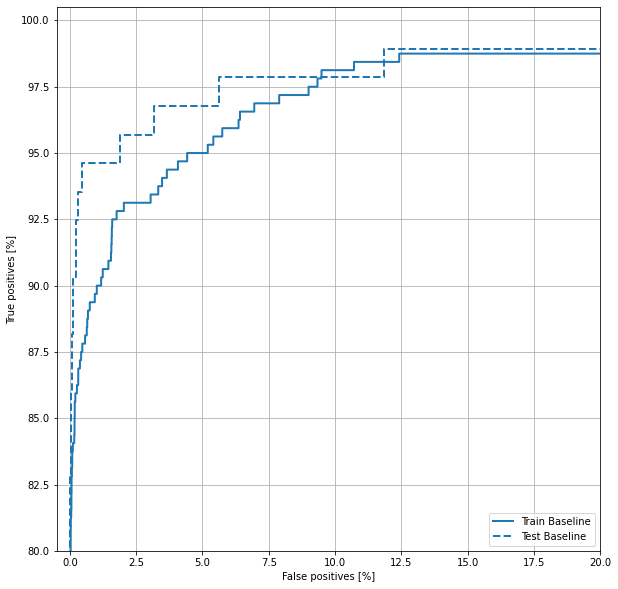

In [90]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [91]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

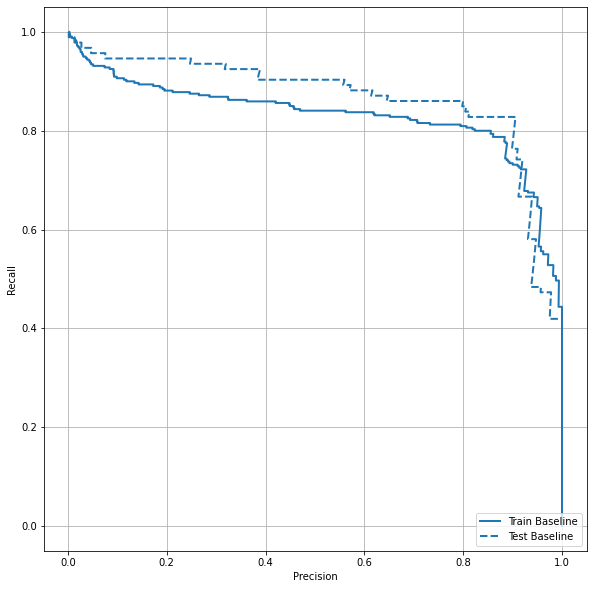

In [92]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [93]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [94]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 4s 17ms/step - loss: 3.7300 - tp: 80.0000 - fp: 33.0000 - tn: 238792.0000 - fn: 333.0000 - accuracy: 0.9985 - precision: 0.7080 - recall: 0.1937 - auc: 0.7007 - prc: 0.2317 - val_loss: 0.0075 - val_tp: 14.0000 - val_fp: 0.0000e+00 - val_tn: 45490.0000 - val_fn: 65.0000 - val_accuracy: 0.9986 - val_precision: 1.0000 - val_recall: 0.1772 - val_auc: 0.9096 - val_prc: 0.4913
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 1.3069 - tp: 121.0000 - fp: 163.0000 - tn: 181793.0000 - fn: 199.0000 - accuracy: 0.9980 - precision: 0.4261 - recall: 0.3781 - auc: 0.8725 - prc: 0.3303 - val_loss: 0.0058 - val_tp: 63.0000 - val_fp: 13.0000 - val_tn: 45477.0000 - val_fn: 16.0000 - val_accuracy: 0.9994 - val_precision: 0.8289 - val_recall: 0.7975 - val_auc: 0.9543 - val_prc: 0.7802
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.8134 - tp: 198.0000 - fp: 404.0000 - tn: 181552.0000 - fn: 122.0000 - acc

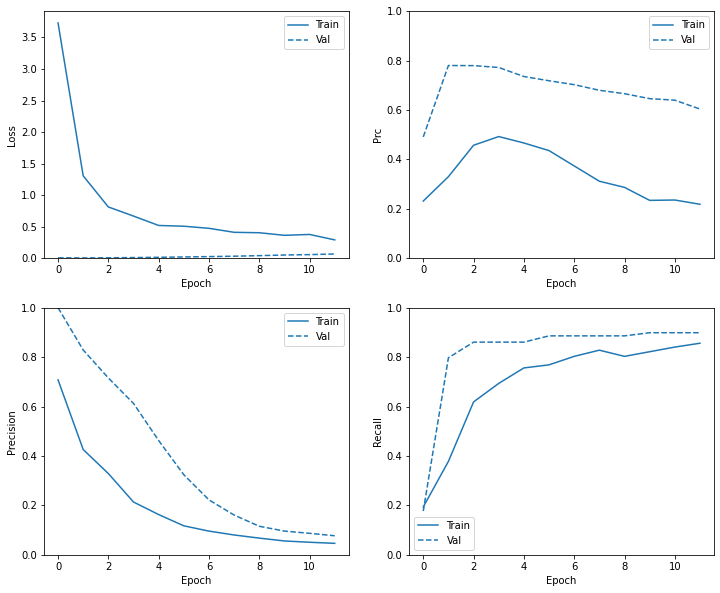

In [95]:
plot_metrics(weighted_history)

In [96]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0057786600664258
tp :  66.0
fp :  16.0
tn :  56853.0
fn :  27.0
accuracy :  0.9992451071739197
precision :  0.8048780560493469
recall :  0.7096773982048035
auc :  0.9587987661361694
prc :  0.7198293209075928

Legitimate Transactions Detected (True Negatives):  56853
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  66
Total Fraudulent Transactions:  93


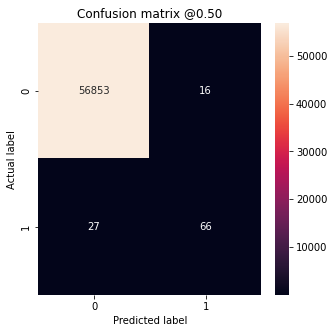

In [97]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

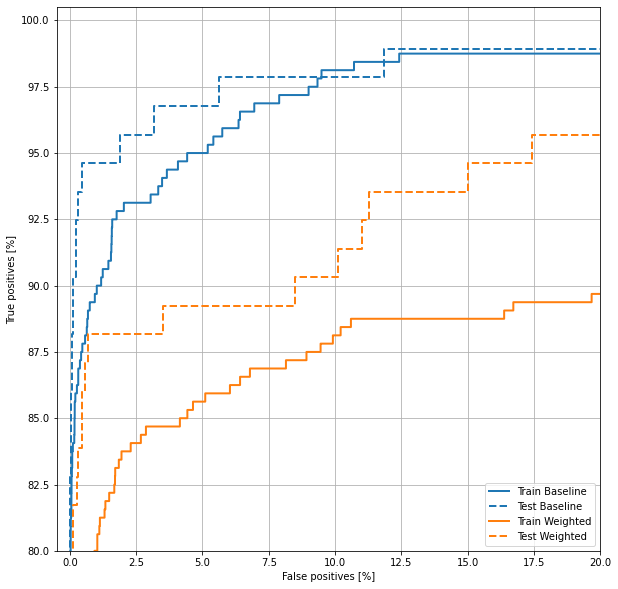

In [98]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

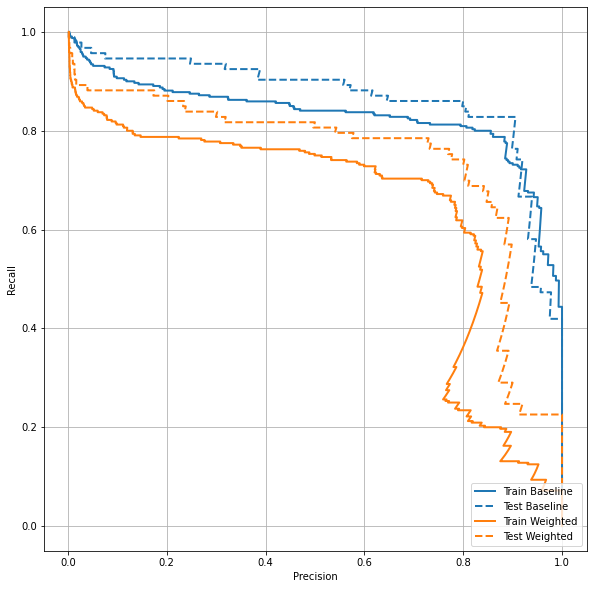

In [99]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

In [100]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [101]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181956, 29)

In [102]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363912, 29)

In [104]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [105]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.63341298  1.62830841 -2.147379    0.96206847 -1.20400095 -1.39666178
 -2.51819363 -1.52329201 -0.19327814 -3.26151444  3.70054605 -5.
 -1.14414766 -5.          1.00675735 -5.         -5.         -3.67513414
  0.16059541  0.74399334  2.48541247 -1.22414093 -0.50324903  0.20259451
 -0.17831436  0.47822786 -0.76860796 -2.2401482   0.5749339 ]

Label:  1


In [106]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [107]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5068359375


In [108]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [109]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 20s 65ms/step - loss: 0.5642 - tp: 216064.0000 - fp: 61343.0000 - tn: 280285.0000 - fn: 68614.0000 - accuracy: 0.7925 - precision: 0.7789 - recall: 0.7590 - auc: 0.8541 - prc: 0.8831 - val_loss: 0.2810 - val_tp: 73.0000 - val_fp: 1715.0000 - val_tn: 43775.0000 - val_fn: 6.0000 - val_accuracy: 0.9622 - val_precision: 0.0408 - val_recall: 0.9241 - val_auc: 0.9605 - val_prc: 0.7778
Epoch 2/100
278/278 [==============================] - 16s 59ms/step - loss: 0.2519 - tp: 249647.0000 - fp: 20168.0000 - tn: 264302.0000 - fn: 35227.0000 - accuracy: 0.9027 - precision: 0.9253 - recall: 0.8763 - auc: 0.9556 - prc: 0.9665 - val_loss: 0.1665 - val_tp: 73.0000 - val_fp: 896.0000 - val_tn: 44594.0000 - val_fn: 6.0000 - val_accuracy: 0.9802 - val_precision: 0.0753 - val_recall: 0.9241 - val_auc: 0.9702 - val_prc: 0.7882
Epoch 3/100
278/278 [==============================] - 17s 61ms/step - loss: 0.2014 - tp: 253731.0000 - fp: 12281.0000 - tn: 27

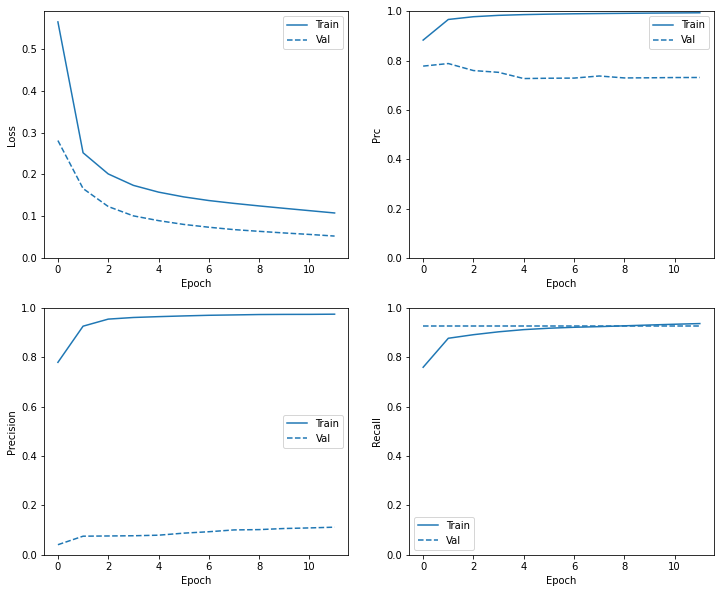

In [110]:
plot_metrics(resampled_history)

In [111]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 8s 165ms/step - loss: 2.0155 - tp: 4284.0000 - fp: 5704.0000 - tn: 60141.0000 - fn: 16400.0000 - accuracy: 0.7445 - precision: 0.4289 - recall: 0.2071 - auc: 0.6240 - prc: 0.3820 - val_loss: 0.4508 - val_tp: 20.0000 - val_fp: 8520.0000 - val_tn: 36970.0000 - val_fn: 59.0000 - val_accuracy: 0.8117 - val_precision: 0.0023 - val_recall: 0.2532 - val_auc: 0.3880 - val_prc: 0.0909
Epoch 2/1000
20/20 [==============================] - 1s 59ms/step - loss: 1.0851 - tp: 8597.0000 - fp: 5770.0000 - tn: 14677.0000 - fn: 11916.0000 - accuracy: 0.5682 - precision: 0.5984 - recall: 0.4191 - auc: 0.5353 - prc: 0.6440 - val_loss: 0.4869 - val_tp: 47.0000 - val_fp: 9970.0000 - val_tn: 35520.0000 - val_fn: 32.0000 - val_accuracy: 0.7805 - val_precision: 0.0047 - val_recall: 0.5949 - val_auc: 0.7482 - val_prc: 0.2253
Epoch 3/1000
20/20 [==============================] - 1s 68ms/step - loss: 0.6756 - tp: 13493.0000 - fp: 6253.0000 - tn: 14001.0000 - f

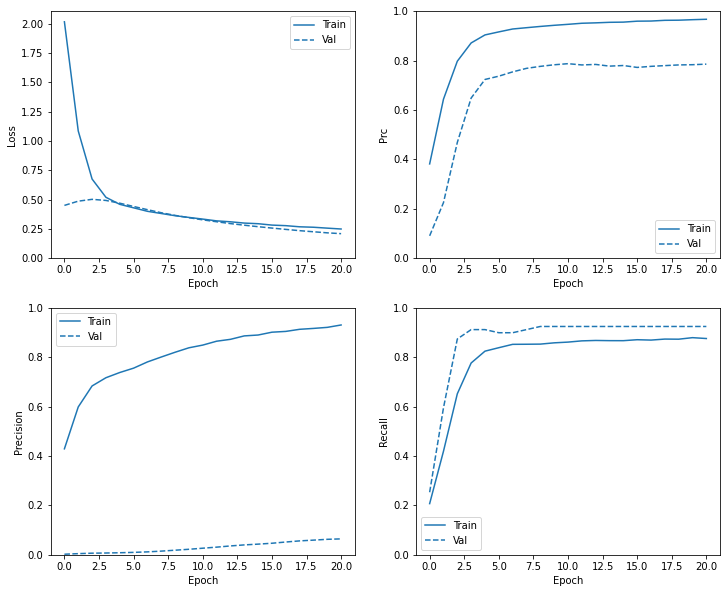

In [112]:
plot_metrics(resampled_history)

In [113]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.32690268754959106
tp :  87.0
fp :  3279.0
tn :  53590.0
fn :  6.0
accuracy :  0.942330002784729
precision :  0.025846702978014946
recall :  0.9354838728904724
auc :  0.9824859499931335
prc :  0.7606278657913208

Legitimate Transactions Detected (True Negatives):  53590
Legitimate Transactions Incorrectly Detected (False Positives):  3279
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  93


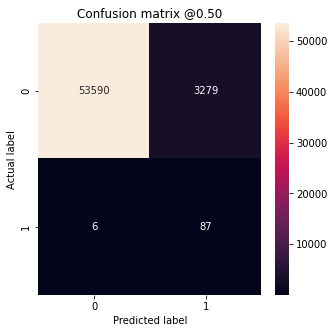

In [114]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

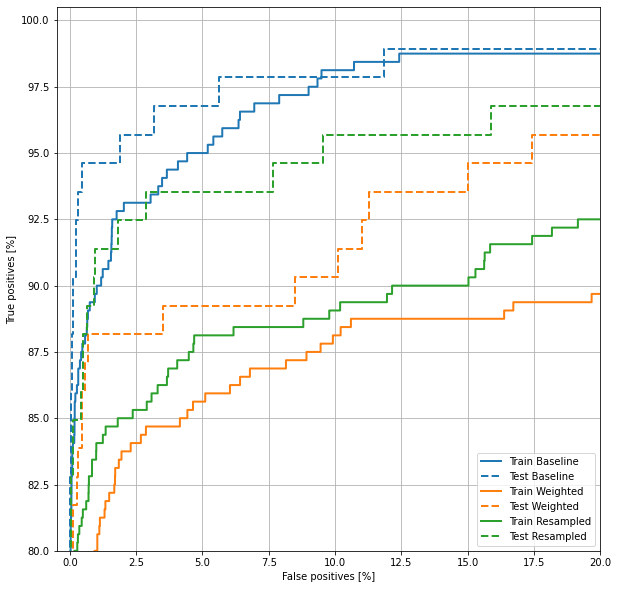

In [115]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

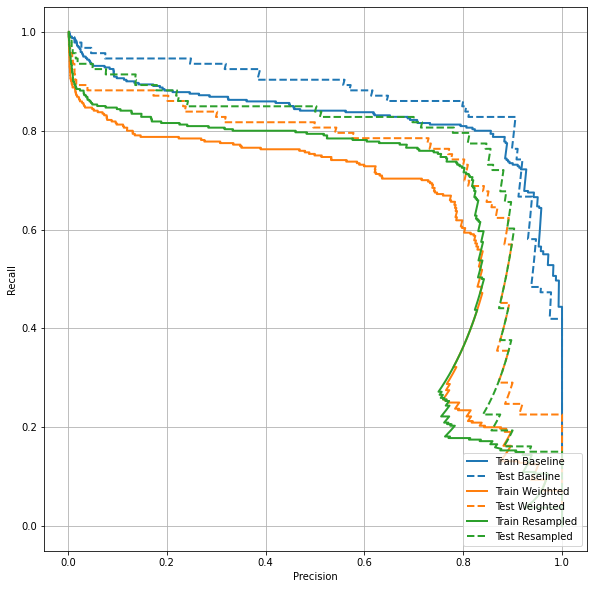

In [116]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');